<a href="https://colab.research.google.com/github/Lokuhu/112-2_2LNN/blob/main/%E5%9B%9BD56_HW5_r_EB_cram_pruning3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
# 試算表>檔案>共用>發布到網路 即可於colab中讀取
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQhbAejyGUXlZltX2nsbC4sTw890L6081piAP8ZDJVbufqZ9xm-S5P7gIrXnpgszm-U9SmEkBxJc5uF/pub?gid=1265524659&single=true&output=csv'
seed = pd.read_csv(url)

In [ ]:
seed['Type'] = seed['Type'].replace(1, 0.0)
seed['Type'] = seed['Type'].replace(2, 1.0)
seed['Type'] = seed['Type'].replace(3, 2.0)
seed

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,2
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,2
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,2
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,2


In [ ]:
# Split data
X = seed.drop('Type',axis=1)
y = seed['Type']

# Covert these to numpy arr
X = X.values
y = y.values

# 20%test, 80%training
X_train, X_test, y_train, y_test=train_test_split (X, y ,test_size = 0.2, random_state = 30)

# Covert X and y to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
class Model5(nn.Module):
    def __init__(self, in_features=7, h1=11, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(p=0.5)  # 添加 Dropout
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)  # 在激活函數之後和輸出層之前添加 Dropout
        x = torch.tanh(self.out(x))
        return x

In [ ]:
# 加入隨機的元素
def prune_hidden_nodes_randomly(model, X_train, y_train, criterion, threshold=0.01, max_unsuccessful_attempts=3):
    unsuccessful_attempts = 0
    while unsuccessful_attempts < max_unsuccessful_attempts:
        h1 = model.fc1.weight.size(0)
        if h1 <= 1:
            break  # 保證至少有一個隱藏節點

        # 隨機選擇一個隱藏節點
        k = random.randint(0, h1 - 1)
        new_h1 = h1 - 1
        new_model = Model5(in_features=7, h1=new_h1, out_features=3)

        with torch.no_grad():
            new_model.fc1.weight = nn.Parameter(torch.cat((model.fc1.weight[:k], model.fc1.weight[k+1:])))
            new_model.fc1.bias = nn.Parameter(torch.cat((model.fc1.bias[:k], model.fc1.bias[k+1:])))
            new_model.out.weight = nn.Parameter(torch.cat((model.out.weight[:, :k], model.out.weight[:, k+1:]), dim=1))
            new_model.out.bias = model.out.bias

        # 計算新損失
        y_pred = new_model(X_train)
        new_loss = criterion(y_pred, y_train)

        # 如果新的損失在可接受範圍內，則保留修剪後的模型
        if new_loss.item() < threshold:
            return new_model
        else:
            unsuccessful_attempts += 1

    return model

# Cramming module: 加上新的hidden nodes，調整權重
def cramming(model, X_train, y_train):
    criterion = nn.CrossEntropyLoss() #定義loss function
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)

    # 找出所有分類錯誤的樣本的index
    incorrect_indices = (y_pred.argmax(dim=1) != y_train).nonzero(as_tuple=True)[0]
    #print("Incorrect indices:", incorrect_indices)

    if len(incorrect_indices) == 0:
        return model

    for i in incorrect_indices:
        new_h1 = model.fc1.weight.size(0) + 3
        new_model = Model5(in_features=7, h1=new_h1, out_features=3)

        with torch.no_grad():
            new_model.fc1.weight[:-3] = model.fc1.weight
            new_model.fc1.bias[:-3] = model.fc1.bias

            new_model.fc1.weight[-3] = X_train[i]
            new_model.fc1.weight[-2] = X_train[i] * 0.5  # Example transformation
            new_model.fc1.weight[-1] = X_train[i] * -0.5

            new_model.fc1.bias[-3] = 1 - X_train[i].sum()
            new_model.fc1.bias[-2] = 1 - (X_train[i] * 0.5).sum()
            new_model.fc1.bias[-1] = 1 - (X_train[i] * -0.5).sum()

            print(f"對 misclassified index {i} 加入三個隱藏節點")

            new_model.out.weight[:, :-3] = model.out.weight
            new_model.out.weight[:, -3:] = 0.0
            new_model.out.bias = model.out.bias

        model = new_model
    return model


In [ ]:
# function of training model
def train_model(model, X_train, y_train, epochs, lr, prune_interval=10, prune_threshold=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    losses = []
    unsuccessful_prune_attempts = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        if epoch % prune_interval == 0 and epoch > 0:
            model = prune_hidden_nodes_randomly(model, X_train, y_train, criterion, threshold=prune_threshold, max_unsuccessful_attempts=3)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # 重建優化器，適應新模型結構

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        loss.backward()
        optimizer.step()

        # 每個EB後逐步修剪不相關的隱藏節點
        model = prune_hidden_nodes_randomly(model, X_train, y_train, criterion, threshold=prune_threshold, max_unsuccessful_attempts=3)
        # 如果有錯誤預測，進行cramming
        model = cramming(model, X_train, y_train)

    return model, losses

In [ ]:
# 初始模型訓練
torch.manual_seed(41)
model5 = Model5()
model5, losses = train_model(model5, X_train, y_train, epochs=100, lr=0.005)

串流輸出內容已截斷至最後 5000 行。
對 misclassified index 26 加入三個隱藏節點
對 misclassified index 27 加入三個隱藏節點
對 misclassified index 30 加入三個隱藏節點
對 misclassified index 31 加入三個隱藏節點
對 misclassified index 32 加入三個隱藏節點
對 misclassified index 34 加入三個隱藏節點
對 misclassified index 35 加入三個隱藏節點
對 misclassified index 36 加入三個隱藏節點
對 misclassified index 37 加入三個隱藏節點
對 misclassified index 38 加入三個隱藏節點
對 misclassified index 39 加入三個隱藏節點
對 misclassified index 40 加入三個隱藏節點
對 misclassified index 41 加入三個隱藏節點
對 misclassified index 42 加入三個隱藏節點
對 misclassified index 44 加入三個隱藏節點
對 misclassified index 45 加入三個隱藏節點
對 misclassified index 47 加入三個隱藏節點
對 misclassified index 48 加入三個隱藏節點
對 misclassified index 51 加入三個隱藏節點
對 misclassified index 52 加入三個隱藏節點
對 misclassified index 53 加入三個隱藏節點
對 misclassified index 58 加入三個隱藏節點
對 misclassified index 59 加入三個隱藏節點
對 misclassified index 60 加入三個隱藏節點
對 misclassified index 61 加入三個隱藏節點
對 misclassified index 62 加入三個隱藏節點
對 misclassified index 63 加入三個隱藏節點
對 misclassified index 66 加入三個隱藏節點
對 misclassified index 67 加入

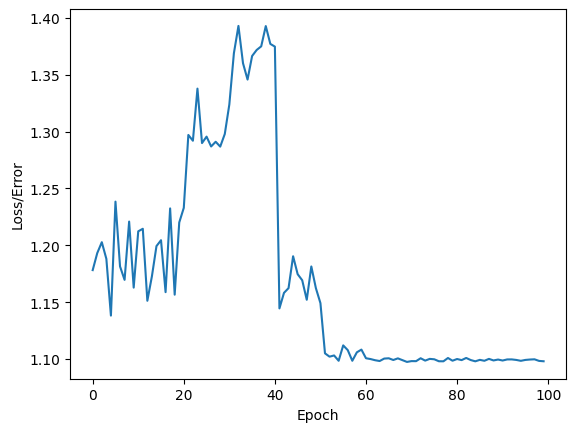

Validation Loss is: 1.0994112491607666
Accuracy is: 0.38095238095238093


In [ ]:
plt.plot(range(len(losses)), losses)
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.show()

# 重新定義全局範圍內的criterion/再研究
criterion = nn.CrossEntropyLoss()

# 評估模型
with torch.no_grad():
    y_eval = model5(X_test)
    loss = criterion(y_eval, y_test)
    correct = (y_eval.argmax(dim=1) == y_test).sum().item()

print(f'Validation Loss is: {loss.item()}')
print(f'Accuracy is: {correct / len(y_test)}')